# Домашняя работа №3

При отправлении ДЗ в Dropbox указывайте фамилию в названии файла: <br\>
** IDA<Номер группы>HW3<Фамилия>.ipynb ** - например ** IDA3HW3Pupkin.ipynb **<br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

<img src="autoencoder.png">

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [1]:
import numpy

import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Загрузка и предобработка данных(2.5 балла).

Загрузите *images.pkl*. Данный файл содержит набор фото. 

In [2]:
import pickle as pkl
import numpy as np

images = np.load(open('images.npy', 'br'))

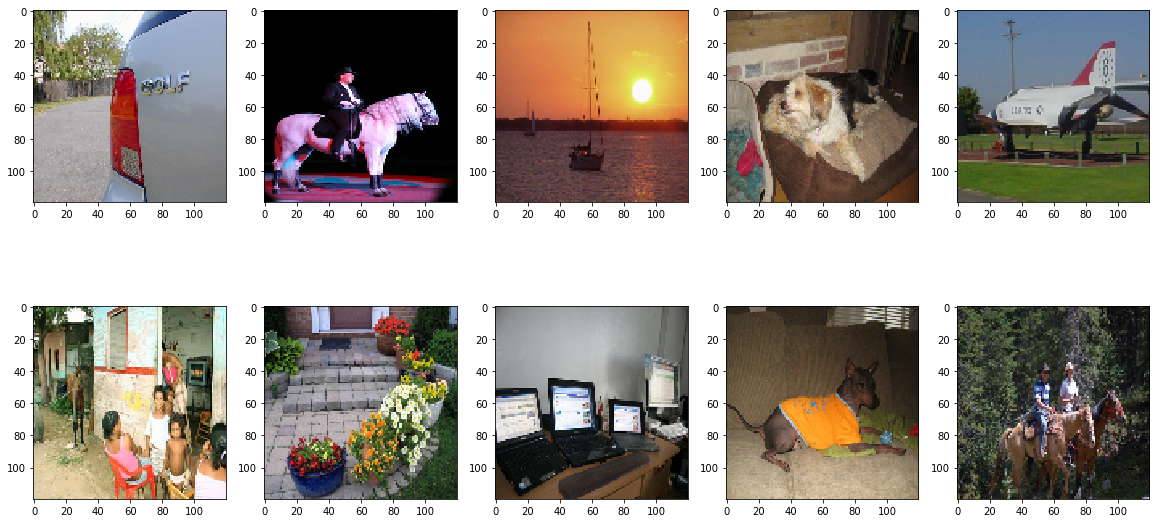

In [3]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])

## Генерация датасета(2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

In [346]:
def get_samples(full_images, num_samples=10000, sample_size=16, rand_seed=123):
    # входные параметры
    # full_images: np.array, исходный датасет
    # num_samples: int, количество патчей, которые функция должна вернуть
    # sample_size: int, длина стороны каждого патча
    # rand_seed: int, число для инициализации np.random.seed, чтобы генерация датасета была воспроизводимой
    numpy.random.seed(rand_seed)
    i = np.random.randint(0, full_images[0].shape[0] - sample_size)
    j = np.random.randint(0, full_images[0].shape[1] - sample_size)
    #np.random.shuffle(full_images)
    res = np.asarray([gg[i:i+sample_size, j:j+sample_size] for gg in full_images[0:1000]])
    # выход функции
    # np.array размера [num_samples, sample_size, sample_size, 3]
    return res
    #pass

In [347]:
pikchi = get_samples(images)

In [348]:
def show_pics(imgs, col, row):
    fig = plt.figure(figsize=(2*col,2*row))
    for i in range(0, col*row ):
        fig.add_subplot(row, col, i + 1)
        plt.imshow(imgs[i])


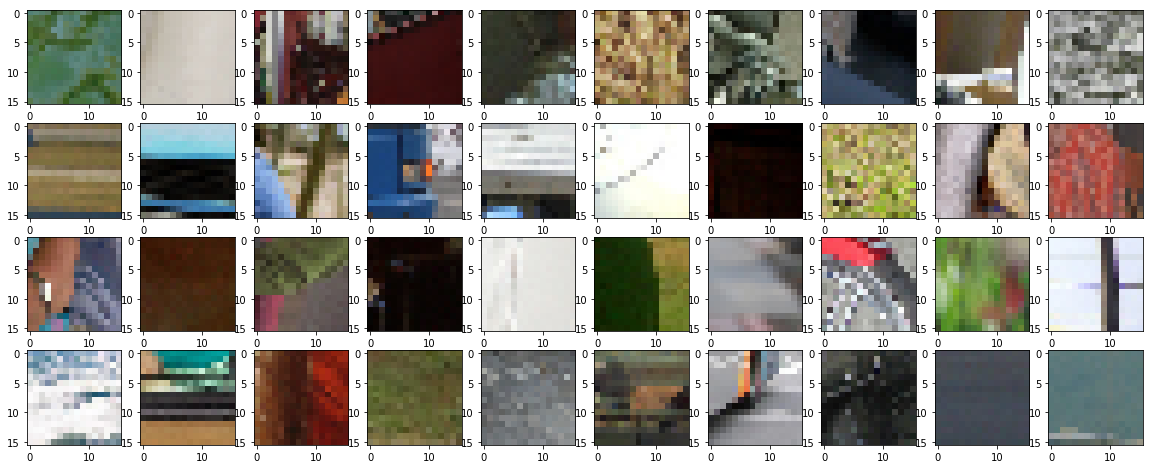

In [349]:
show_pics(pikchi, 10, 4)

## Нормировка картинок и вытягивание их в один вектор(0.5 балл)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

In [381]:
for i in [0, 1, 2]:
    pikchi[:, :, :, i] = (pikchi[:, :, :, i] - pikchi[:, :, :, i].min())*((0.9 - 0.1)/(pikchi[:, :, :, i].max() - pikchi[:, :, :, i].min())) + 0.1 

Преобразуйте каждый семпл-матрицу в вектор.

То есть из исходного набора сэмплов размера [num_samples, sample_size, sample_size, 3] должен получиться набор размера [num_samples, sample_size x sample_size x 3].

In [382]:
pikchi.shape

(1000, 16, 16, 3)

In [383]:
pikchi = pikchi.reshape((len(pikchi),np.prod(pikchi.shape[1:])))

In [384]:
pikchi.shape

(1000, 768)

# Реализация и обучение автокодировщика(4 балла)

### Построение автокодировщика(1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [465]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense

In [470]:
def create_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400]):
    # входные параметры:
    # object_size: int, размер входного и выходного слоя автоэнкодера
    # encoder_layer_shapes: list of int, количество нейронов в каждом слое энкодера. 
    #                       последний элемент списка - размер "бутылочного горлышка"
    # decoder_layer_shapes: list of int, количество нейронов в каждом слое декодера
    input_img = Input(shape=(object_size,))
    
    encoded = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    
    for i in encoder_layer_shapes[1:]:
        encoded = Dense(i, activation='relu')(encoded)
    
    decoded = Dense(decoder_layer_shapes[0], activation='relu')(encoded)
    
    for i in decoder_layer_shapes[1:len(decoder_layer_shapes)]:
        decoded = Dense(i, activation='relu')(decoded)
    
    decoded = Dense(object_size, activation='sigmoid')(decoded)
    # выход:
    # keras модель
    model = Model(input_img, decoded)
    return model

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [476]:
autoencoder = create_autoencoder_model()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 768)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 256)               196864    
_________________________________________________________________
dense_124 (Dense)            (None, 144)               37008     
_________________________________________________________________
dense_125 (Dense)            (None, 64)                9280      
_________________________________________________________________
dense_126 (Dense)            (None, 200)               13000     
_________________________________________________________________
dense_127 (Dense)            (None, 400)               80400     
_________________________________________________________________
dense_128 (Dense)            (None, 768)               307968    
Total para

In [472]:
np.random.shuffle(pikchi)
x_train, x_test = pikchi[:900], pikchi[900:] 

In [477]:
autoencoder.compile(loss='mean_squared_error',
              optimizer='adam')
hist = autoencoder.fit(x_train, x_train,
          batch_size=100,
          epochs=100,
          validation_data=(x_test, x_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0464 - val_loss: 0.0483
Epoch 2/100
900/900 [==============================] - 0s 312us/step - loss: 0.0445 - val_loss: 0.0459
Epoch 3/100
900/900 [==============================] - 0s 340us/step - loss: 0.0406 - val_loss: 0.0411
Epoch 4/100
900/900 [==============================] - 0s 313us/step - loss: 0.0365 - val_loss: 0.0435
Epoch 5/100
900/900 [==============================] - 0s 315us/step - loss: 0.0353 - val_loss: 0.0392
Epoch 6/100
900/900 [==============================] - 0s 316us/step - loss: 0.0302 - val_loss: 0.0277
Epoch 7/100
900/900 [==============================] - 0s 321us/step - loss: 0.0267 - val_loss: 0.0247
Epoch 8/100
900/900 [==============================] - 0s 349us/step - loss: 0.0203 - val_loss: 0.0171
Epoch 9/100
900/900 [==============================] - 0s 403us/step - loss: 0.0176 - val_loss: 0.0139
Epoch 10/100
900/900 [=======

In [457]:
score = autoencoder.evaluate(x_test, x_test, verbose=0)
print('mse on validation:', score)

mse on validation: 0.0064707383886


Обучите модель со стандартными параметрами.

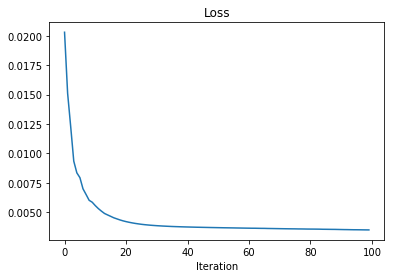

In [413]:
plt.title('Loss')
plt.xlabel('Iteration')
plt.plot(hist.history['loss'])

### Визуализация паттернов, которые находят нейроны(1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

In [414]:
x_pred = autoencoder.predict(x_test[:7])
x_pred = x_pred.reshape((len(x_pred), 16, 16, 3))

In [415]:
tmp = np.copy(x_test[:7].reshape(7, 16, 16, 3))

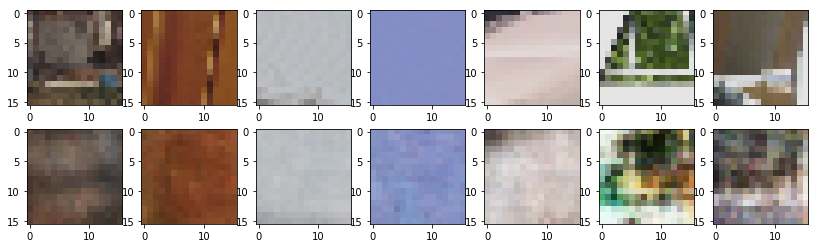

In [416]:
show_pics(np.concatenate((tmp, x_pred)), 7, 2)

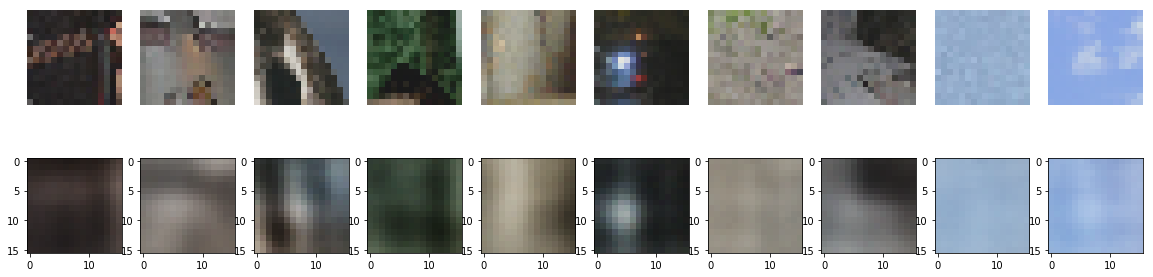

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

In [304]:
inp = autoencoder.inputs
outputs = [i.output for i in autoencoder.layers]

In [308]:
functors = [keras.backend.function([inp]+ [keras.backend.learning_phase()], [out]) for out in outputs]  # evaluation functions

In [445]:
layer_outs = [func([x_test]) for func in functors]
print(layer_outs)

TypeError: unhashable type: 'list'

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

In [490]:
autoencoder1 = create_autoencoder_model(768, [256, 200, 144, 64], decoder_layer_shapes=[100, 300, 500, 600])

In [491]:
autoencoder1.compile(loss='mean_squared_error',
              optimizer='adam')
hist = autoencoder1.fit(x_train, x_train,
          batch_size=200,
          epochs=150,
          validation_data=(x_test, x_test))

Train on 900 samples, validate on 100 samples
Epoch 1/150
900/900 [==============================] - 5s 5ms/step - loss: 0.0468 - val_loss: 0.0488
Epoch 2/150
900/900 [==============================] - 0s 530us/step - loss: 0.0447 - val_loss: 0.0459
Epoch 3/150
900/900 [==============================] - 1s 565us/step - loss: 0.0401 - val_loss: 0.0451
Epoch 4/150
900/900 [==============================] - 0s 522us/step - loss: 0.0431 - val_loss: 0.0443
Epoch 5/150
900/900 [==============================] - 0s 552us/step - loss: 0.0397 - val_loss: 0.0362
Epoch 6/150
900/900 [==============================] - 0s 533us/step - loss: 0.0421 - val_loss: 0.0470
Epoch 7/150
900/900 [==============================] - 0s 541us/step - loss: 0.0408 - val_loss: 0.0417
Epoch 8/150
900/900 [==============================] - 0s 553us/step - loss: 0.0344 - val_loss: 0.0305
Epoch 9/150
900/900 [==============================] - 1s 558us/step - loss: 0.0256 - val_loss: 0.0212
Epoch 10/150
900/900 [=======

# Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [426]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Сожмите данные автокодировщиком, у которого только один скрытый слой(по сути только bottleneck) с 30 нейронами.

In [435]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [436]:
x_train.shape[1]

784

In [437]:
input_img = Input(shape=(x_train.shape[1],))
encoded = Dense(30, activation='relu')(input_img)
decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)
model1 = Model(input_img, decoded)

In [438]:
model1.compile(loss='mean_squared_error',
              optimizer='adam')

In [439]:
mnist_hist = model1.fit(x_train, x_train,
          batch_size=300,
          epochs=100,
          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.0759 - val_loss: 0.0468
Epoch 2/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.0395 - val_loss: 0.0334
Epoch 3/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.0302 - val_loss: 0.0264
Epoch 4/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.0243 - val_loss: 0.0216
Epoch 5/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.0205 - val_loss: 0.0187
Epoch 6/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.0180 - val_loss: 0.0167
Epoch 7/100
60000/60000 [==============================] - 4s 63us/step - loss: 0.0163 - val_loss: 0.0153
Epoch 8/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.0151 - val_loss: 0.0142
Epoch 9/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.0141 - val_loss: 0.0

Возьмите несколько моделей из sklearn (KNN,SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты(точность) на тесте?

### CIFAR10(2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [492]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 1395s 8us/step


In [493]:
x_train.shape

(50000, 32, 32, 3)

In [494]:
x_train = get_samples(x_train, len(x_train), 8)

In [495]:
x_train.shape

(1000, 8, 8, 3)

In [502]:
x_test = get_samples(x_test, len(x_test), 8)

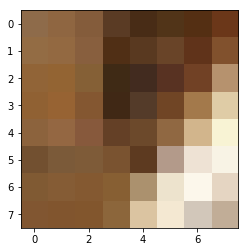

In [499]:
plt.imshow(x_train[0])

In [507]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(1000, 192)
(1000, 192)


In [508]:
input_img = Input(shape=(x_train.shape[1],))
encoded = Dense(30, activation='relu')(input_img)
decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)
model2 = Model(input_img, decoded)

In [509]:
model2.compile(loss='mean_squared_error',
              optimizer='adam')

In [510]:
mnist_hist = model2.fit(x_train, x_train,
          batch_size=32,
          epochs=100,
          validation_data=(x_test, x_test))

Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0574 - val_loss: 0.0586
Epoch 2/100
1000/1000 [==============================] - 0s 197us/step - loss: 0.0542 - val_loss: 0.0541
Epoch 3/100
1000/1000 [==============================] - 0s 183us/step - loss: 0.0485 - val_loss: 0.0464
Epoch 4/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0415 - val_loss: 0.0382
Epoch 5/100
1000/1000 [==============================] - 0s 189us/step - loss: 0.0352 - val_loss: 0.0328
Epoch 6/100
1000/1000 [==============================] - 0s 178us/step - loss: 0.0311 - val_loss: 0.0288
Epoch 7/100
1000/1000 [==============================] - 0s 177us/step - loss: 0.0278 - val_loss: 0.0266
Epoch 8/100
1000/1000 [==============================] - 0s 189us/step - loss: 0.0253 - val_loss: 0.0238
Epoch 9/100
1000/1000 [==============================] - 0s 186us/step - loss: 0.0231 - val_loss: 0.0226
Epoch 10/

Теперь разделите каждую картинку из датасета на 16 сэмплjd размера 8x8, закодируйте их через энкодер и склейте 16 выходов энкодера в один вектор. Каждый объект в итоге должен кодироваться 16 * 30 = 380 признаками.

Теперь обучите SVM на преобразованных объектах и выведите точность.